In [28]:
import os
import json
import typing as tp
import warnings
import random

import pandas as pd
import numpy as np
from tqdm import tqdm

warnings.filterwarnings("ignore")

client_profiles: pd.DataFrame = pd.read_csv("data/client_profiles.csv")
course_descriptions: tp.List[tp.Dict[str, tp.Any]] = json.load(
    open("data/200_sport_programs.json")
)

In [29]:
def prepare_documents(raw_docs: tp.List[tp.Dict[str, tp.Any]]) -> tp.List[str]:
    docs: tp.List[str] = []
    for doc in raw_docs:
        formatted_doc = "\n".join([f"{k}: {str(v)}" for k, v in doc.items()])
        docs.append(formatted_doc)
    return docs

In [30]:
def safe_str(val: tp.Any) -> str:
    if pd.isna(val):
        return "N/A"
    if isinstance(val, list):
        return '\n'.join(map(str, val))
    return str(val)

def stringify_profile(row):
    return (
        f"Name: {safe_str(row['personal_data.full_name'])}.\n"
        f"Gender: {safe_str(row['basic_information.gender'])}, Age: {safe_str(row['basic_information.age'])}\n"
        f"Height: {safe_str(row['basic_information.height_cm'])} cm, Weight: {safe_str(row['basic_information.weight_kg'])} kg.\n"
        f"Training goals: {safe_str(row['training_goals'])}.\n"
        f"Experience: {safe_str(row['training_experience.level'])}\n"
        f"({safe_str(row['training_experience.frequency_last_3_months'])}).\n"
        f"Prefers training at: {safe_str(row['preferences.training_location'])}\n"
        f"({safe_str(row['preferences.location_details'])}),\n"
        f"Session duration: {safe_str(row['preferences.session_duration'])}.\n"
        f"Joint/back problems: {safe_str(row['health.joint_back_problems'])},\n"
        f"Chronic conditions: {safe_str(row['health.chronic_conditions'])},\n"
        f"Health details: {safe_str(row['health.health_details'])}.\n"
        f"Strength training: {safe_str(row['training_types.strength_training'])}\n"
        f"Cardio: {safe_str(row['training_types.cardio'])}\n"
        f"HIIT: {safe_str(row['training_types.hiit'])}\n"
        f"Yoga/Pilates: {safe_str(row['training_types.yoga_pilates'])}\n"
        f"Functional training: {safe_str(row['training_types.functional_training'])}\n"
        f"Stretching: {safe_str(row['training_types.stretching'])}"
    )

client_profiles['stringified'] = client_profiles.apply(stringify_profile, axis=1)

---

#### Create metadata for each user profile to ensure user vector diversity

In [31]:
from prompts import GENERATE_USER_METADATA_PROMPT as prompt

available_programs: tp.List[tp.Dict[str, str]] = [
    {"name": "Beginner Home Strength"},
    {"name": "Cardio Burnout"},
    {"name": "Yoga for Flexibility"},
    {"name": "Senior Functional Fitness"},
    {"name": "Boxing Bootcamp"},
    {"name": "HIIT Express"},
    {"name": "Pilates Core Builder"},
    {"name": "CrossFit Challenge"},
    {"name": "Bodybuilding Basics"},
    {"name": "Stretch & Recover"},
    {"name": "Swimming Endurance"},
    {"name": "Cycling Power"},
    {"name": "Dance Cardio"},
    {"name": "Rehabilitation Mobility"},
    {"name": "Morning Energy Yoga"},
]

seed_phrases: tp.List[str] = [
    "Motivated beginner eager to get fit",
    "Experienced athlete recovering from injury",
    "Busy professional with limited time for workouts",
    "Senior looking to improve mobility and balance",
    "Young adult training for a marathon",
    "New mother seeking postnatal fitness",
    "Student interested in stress relief and flexibility",
    "Overweight individual aiming for weight loss",
    "Fitness enthusiast exploring new training styles",
    "Person with joint issues needing low-impact routines",
    "Gym regular wanting to build muscle mass",
    "Outdoor lover preferring nature workouts",
    "Cardio fan aiming to boost endurance",
    "Yoga devotee seeking advanced poses",
    "Beginner intimidated by gym equipment",
    "Parent looking for family-friendly workouts",
    "Traveler needing portable, equipment-free routines",
    "Retiree focused on active longevity",
    "Person with diabetes managing health through exercise",
    "Night owl preferring late evening sessions",
]
metadata_prompts: tp.List[str] = []
for i in tqdm(range(len(client_profiles))):
    user_seed_phrases = random.sample(seed_phrases, 3)
    for seed_phrase in user_seed_phrases:
        metadata_prompts.append(
            prompt.format(
                user_profile=client_profiles.iloc[i]["stringified"],
                seed_phrase=seed_phrase,
                available_programs="\n".join([p["name"] for p in available_programs]),
            )
        )

100%|██████████| 39/39 [00:00<00:00, 7144.39it/s]


In [32]:
from client_form_synt_data import get_response

metadata: tp.List[str] = []

for i in tqdm(range(len(metadata_prompts))):
    response: str = str(
        get_response(
            model_name="gemma",
            user_prompt=metadata_prompts[i],
            system_prompt="You are a helpful assistant.",
        )
        .choices[0]
        .message.content
    )
    metadata.append(response)

100%|██████████| 117/117 [14:48<00:00,  7.60s/it]


In [33]:
with open("data/user_metadata.json", "w") as f:
    f.write(json.dumps(metadata, indent=4, ensure_ascii=False))

In [34]:
#### Map metadata to client profiles
metadata_reshaped: tp.List[tp.List[str]] = []
for i in range(0, len(metadata), 3):
    metadata_reshaped.append(metadata[i : i + 3])

assert len(metadata_reshaped) == len(
    client_profiles
), f"Metadata groups: {len(metadata_reshaped)}, Client profiles: {len(client_profiles)}"

In [36]:
for i in range(len(client_profiles)):
    client_profiles.at[i, "metadata"] = metadata_reshaped[i]

In [37]:
users_stringified: tp.List[str] = []

def preprocess_metadata(meta: str) -> str:
    return meta.replace("```json", "").replace("```", "").strip()

for idx, user in client_profiles.iterrows():
    user_profile: str = user["stringified"] # type: ignore
    user_metas: tp.List[str] = user["metadata"] # type: ignore
    for meta in user_metas:
        users_stringified.append(f"{preprocess_metadata(meta)}\n{user_profile}")

In [38]:
with open("data/user_with_metadata.json", "w") as f:
    json.dump(users_stringified, f, indent=4, ensure_ascii=False)

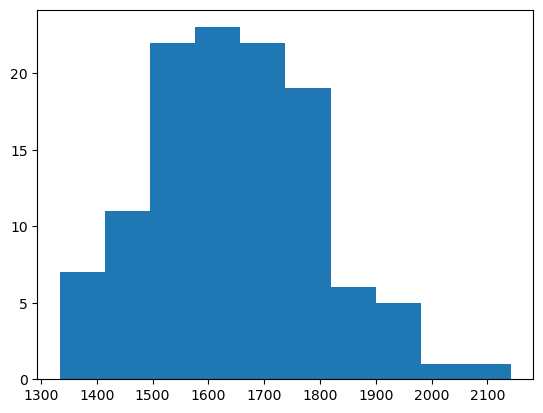

In [44]:
import matplotlib.pyplot as plt

plt.hist([len(user) for user in users_stringified])
plt.show()

---

#### Prepare prompts for Deepseek

In [59]:
REARRANGE_PROGRAMS_PROMPT = """You are an expert in personalized sport program recommendations.

Given:
- A user profile describing the client's characteristics, goals, preferences, and health information.
- A list of sport programs, each with a unique ID and description.

**Task:**  
Select the single most relevant sport program for this user based on their profile.  
Return only the program ID of the most relevant course as plain text, with no explanation or formatting.

**Example output:**
12

**User Profile:**
{user_profile}

**Sport Programs:**
{programs}
"""

In [62]:
from tqdm import tqdm

training_data = []
for user in tqdm(users_stringified):
    formatted_prompt = REARRANGE_PROGRAMS_PROMPT.format(
        user_profile=user,
        programs="\n".join(
            [
                f"Program#{i}: {str(p)[:100]}..."
                for i, p in enumerate(available_programs)
            ]
        ),
    )
    response = get_response(
        model_name="gemma",
        user_prompt=formatted_prompt,
        system_prompt="You are a helpful assistant.",
    )
    training_data.append(response)

100%|██████████| 117/117 [03:49<00:00,  1.96s/it]


In [64]:
df = []
for idx, item in enumerate(training_data):
    course_id: int = int(item.choices[0].message.content)
    user_profile_w_meta: str = users_stringified[idx]
    course_description: tp.Dict[str, tp.Any] = course_descriptions[course_id]
    df.append((idx, course_id, user_profile_w_meta, course_description))

In [65]:
df = pd.DataFrame(
    df, columns=["id", "course_id", "user_profile_w_meta", "course_description"]
)

In [66]:
df.to_csv("data/dataset.csv", index=False)